<a href="https://colab.research.google.com/github/afjames2012/afjames2012.github.io/blob/main/241125_LRP_S_model_with_some_debug_modifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

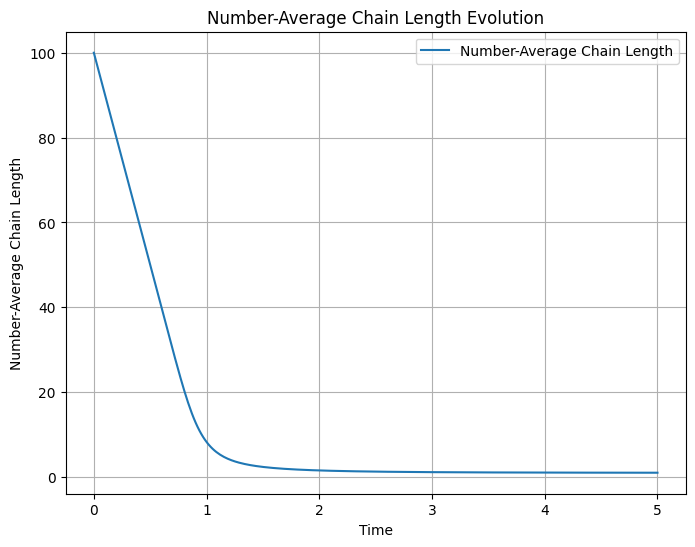

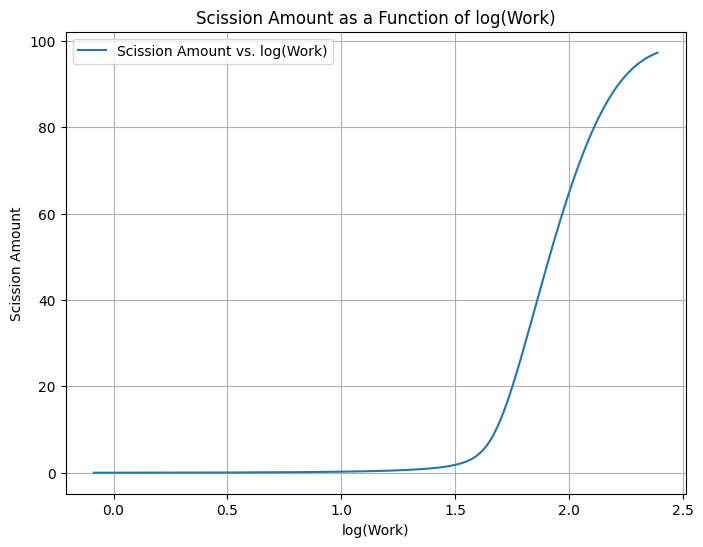

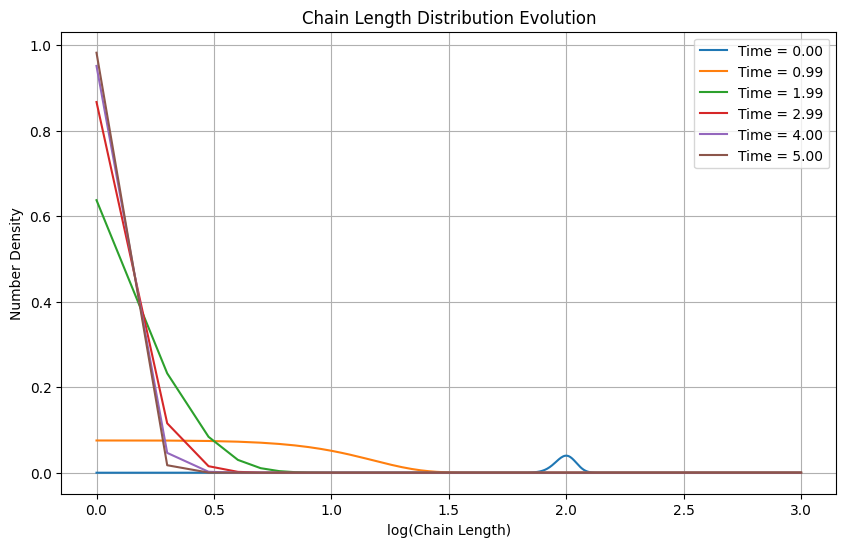

Data successfully saved to Scission_and_Distribution.xlsx


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import cumtrapz
import pandas as pd  # For Excel export

# Constants for the LRP-S model
alpha_e = 2          # Entanglement persistence parameter
beta = 1           # CCR effectiveness parameter
gamma = 7     # Strain rate scaling parameter
mean = 70        # Mean chain length
Z = mean/alpha_e         # Entanglement number
A = 1            # Prefactor for scission rate or equilibrium scission constant
zeta = 1/(mean**4)       # Fast-breaking limit parameter
viscosity = 1.0      # Viscosity of the fluid

# Define effective relaxation parameter theta_eff
def theta_eff(zeta, l_hat):
    if l_hat < 1e-8:
        print(f"Warning: l_hat is too small ({l_hat}). Setting to minimum threshold.")
        l_hat = 1e-8
    prefactor = (3 * Z) / (l_hat**2)
    log_term = np.log(max(2 / (3 * l_hat * Z * zeta), 1e-8))  # Avoid log(0)
    scaling_factor = (3**(3/2)) / (2**(4/3) * np.pi)
    return prefactor * scaling_factor * zeta**(1/3) * log_term


# Calculate effective average chain length l_hat
def average_chain_length(Q0):
    trQ0 = np.trace(Q0)
    return np.exp(-1 / (4 * alpha_e) * (trQ0 - 3))

# Dynamic scission rate k_sc(l) based on tr(Q)
def scission_rate(tr_Q):
    return A * np.exp((1 / (2 * alpha_e)) * (tr_Q - 3))

# Evolve chain length distribution over time
def evolve_chain_distribution(chain_lengths, initial_distributions, time, Q0):
    tr_Q0 = np.trace(Q0)
    scission_rates = scission_rate(tr_Q0) * chain_lengths
    evolved_distribution = initial_distributions * np.exp(-scission_rates * time)
    normalization = np.sum(evolved_distribution)
    return evolved_distribution / normalization if normalization != 0 else initial_distributions

# Calculate Q0 from evolving chain distribution
def calculate_Q0_from_distribution(chain_lengths, distributions, Q_tensors):
    weighted_sum = sum(distributions[i] * Q_tensors[i] for i in range(len(chain_lengths)))
    normalization = sum(distributions)
    return weighted_sum / normalization if normalization != 0 else np.eye(3)

# Configuration tensor evolution for the simplified LRP-S model
def configuration_tensor_evolution(t, Q_flat, flow_field, gamma, zeta):
    Q0 = np.reshape(Q_flat, (3, 3))  # Reshape Q_flat into a 3x3 matrix
    l_hat = average_chain_length(Q0)
    if l_hat < 1e-8:
        print(f"Warning: l_hat too small ({l_hat}). Setting to minimum threshold.")
        l_hat = 1e-8

    theta = theta_eff(zeta, l_hat)
    lambda0 = np.sqrt(max(np.trace(Q0) / 3, 0))  # Avoid sqrt of negative or zero
    if lambda0 < 1e-8:
        print(f"Warning: lambda0 too small ({lambda0}). Setting to minimum threshold.")
        lambda0 = 1e-8

    Wi = (3**(3/2)) / (2**(4/3) * np.pi) * gamma * zeta**(1/3)
    convective_term = Wi * (np.dot(flow_field.T, Q0) + np.dot(Q0, flow_field))
    reptation_term = -(1 / l_hat**3) * (Q0 - np.eye(3))
    retraction_term = -theta * (1 - 1 / lambda0) * (Q0 + (beta / lambda0) * (Q0 - np.eye(3)))

    dQ0_dt = convective_term + reptation_term + retraction_term
    return dQ0_dt.flatten()


# Initial Gaussian distribution setup
chain_lengths = np.linspace(1, 1000, 1000)
mean_length = 100.0
std_dev = 10.0
initial_distributions = np.array([1 / (std_dev * np.sqrt(2 * np.pi)) * np.exp(-((l - mean_length)**2) / (2 * std_dev**2)) for l in chain_lengths])


# Initial Q0 setup with perturbation
perturbation_strength = 0.01
random_perturbation = np.random.uniform(-perturbation_strength, perturbation_strength, (3, 3))
random_perturbation = (random_perturbation + random_perturbation.T) / 2  # Symmetrize
initial_Q0 = (np.eye(3) + random_perturbation).flatten()


# Flow field for simple shear
flow_field = np.array([[0, gamma, 0], [0, 0, 0], [0, 0, 0]])

# Time evolution parameters
time_span = (0, 5)
time_points = np.linspace(0, 5, 300)

# Solve configuration tensor evolution
solution = solve_ivp(
    configuration_tensor_evolution,
    time_span,
    initial_Q0,
    args=(flow_field, gamma, zeta),
    t_eval=time_points,
    method='RK45',
)

# Initialize Q_tensors for each chain length
Q_tensors = [np.eye(3) for _ in chain_lengths]

# Number-average chain length, scission amount, and work over time
number_average_lengths = []
distribution_over_time = []
scission_amounts = []
work_values = []

initial_number_average_length = np.sum(chain_lengths * initial_distributions) / np.sum(initial_distributions)

for t_idx, t in enumerate(time_points):
    # Evolve chain length distribution
    Q0 = np.reshape(solution.y[:, t_idx], (3, 3))
    evolved_distribution = evolve_chain_distribution(chain_lengths, initial_distributions, t, Q0)

    # Recompute Q0 based on the evolving chain distribution
    Q0 = calculate_Q0_from_distribution(chain_lengths, evolved_distribution, Q_tensors)

    # Compute number-average chain length
    avg_length = np.sum(chain_lengths * evolved_distribution) / np.sum(evolved_distribution)
    number_average_lengths.append(avg_length)
    distribution_over_time.append(evolved_distribution)

    # Compute scission amount
    scission_amount = (initial_number_average_length - avg_length) / avg_length if avg_length != 0 else 0
    scission_amounts.append(scission_amount)

    # Compute work as integral of gamma^2 over time
    if t_idx > 0:
        work = np.trapz(
            [viscosity * gamma**2 for _ in time_points[:t_idx+1]],
            time_points[:t_idx+1]
        )
    else:
        work = 0
    work_values.append(work)

# Filter out zero work to avoid log(0) errors
work_values_nonzero = [w for w in work_values if w > 0]
scission_amounts_nonzero = [scission_amounts[idx] for idx, w in enumerate(work_values) if w > 0]

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(time_points, number_average_lengths, label='Number-Average Chain Length')
plt.xlabel('Time')
plt.ylabel('Number-Average Chain Length')
plt.title('Number-Average Chain Length Evolution')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(np.log10(work_values_nonzero), scission_amounts_nonzero, label='Scission Amount vs. log(Work)')
plt.xlabel('log(Work)')
plt.ylabel('Scission Amount')
plt.title('Scission Amount as a Function of log(Work)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for idx, t in enumerate(np.linspace(0, len(time_points) - 1, 6, dtype=int)):
    plt.plot(np.log10(chain_lengths), distribution_over_time[t], label=f'Time = {time_points[t]:.2f}')
plt.xlabel('log(Chain Length)')
plt.ylabel('Number Density')
plt.title('Chain Length Distribution Evolution')
plt.legend()
plt.grid(True)
plt.show()

# Prepare scission amount as a function of time and work
scission_data = {
    "Time": time_points,
    "Work": work_values,
    "Scission Amount": scission_amounts
}
scission_df = pd.DataFrame(scission_data)

# Prepare chain length distributions over time
distribution_data = {
    "Chain Length": chain_lengths
}
for idx, t in enumerate(time_points):
    distribution_data[f"Time {t:.2f}"] = distribution_over_time[idx]

distribution_df = pd.DataFrame(distribution_data)

# Save data to an Excel file with multiple sheets
output_path = "Scission_and_Distribution.xlsx"
with pd.ExcelWriter(output_path) as writer:
    scission_df.to_excel(writer, sheet_name="Scission vs Time & Work", index=False)
    distribution_df.to_excel(writer, sheet_name="Chain Length Distributions", index=False)

print(f"Data successfully saved to {output_path}")
